<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Removing `if` Statements from Expressions 

## Author: Patrick Nelson

### NRPy+ Source Code for this module: 
* [Min_Max_and_Piecewise_Expressions.py](../edit/Min_Max_and_Piecewise_Expressions.py) Contains functions that can be used to compute the minimum or maximum of two values and to implement piecewise-defined expressions 

## Introduction:

Conditional statements are a critical tool in programming, allowing us to control the flow through a program to avoid pitfalls, code piecewise-defined functions, and so forth. However, there are times when it is useful to work around them. It takes a processor time to evaluate the whether or not to execute the code block, so for some expressions, performance can be improved by rewriting the expression to use an absolute value function in a manner upon which we will expand in this tutorial. Even more relevant to NRPy+ are piecewise-defined functions. These inherently involve `if` statements, but NRPy+'s automatic code generation cannot handle these by itself, requiring hand-coding to be done. However, if it is possible to rewrite the expression in terms of absolute values, then NRPy+ can handle the entire thing itself. 

The absolute value is a function that simply returns the magnitude of its argument, a positive value. That is, 
\begin{align}
|x|&= \left \{ \begin{array}{lll}x & \mbox{if} & x \geq 0 \\
-x & \mbox{if} & x \leq 0 \end{array} \right. \\
\end{align}

In C, this is implemented as `fabs()`, which merely has to make the first bit of a double-precision floating point number 0, and is thus quite fast. 

There are myriad uses for these tricks in practice. One example comes from GRMHD (and, by extension, the special cases of GRFFE and GRHD), in which it is necessary to limit the velocity of the plasma in order to keep the simulations stable. This is done by calculating the Lorentz factor $\Gamma$ of the plasma and comparing to some predefined maximum $\Gamma_\max$. Then, if
$$
R = 1-\frac{1}{\Gamma^2} > 1-\frac{1}{\Gamma_{\max}^2} = R_\max,
$$
we rescale the velocities by $\sqrt{R_\max/R}$. In NRPy+, we instead always rescale by
$$
\sqrt{\frac{\min(R,R_\max)}{R+\epsilon}},
$$
which has the same effect while allowing the entire process to be handled by NRPy+'s automatic code generation. ($\epsilon$ is some small number chosen to avoid division by zero without affecting the results otherwise.) See [here](Tutorial-GRHD_Equations-Cartesian.ipynb#convertvtou) for more information on this. 

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#min_max): Minimum and Maximum
    1. [Step 1.a](#confirm): Confirm that these work for real numbers
1. [Step 2](#piecewise): Piecewise-defined functions
1. [Step 3](#sympy): Rewrite functions to work with symbolic expressions
1. [Step 4](#validation): Validation against `Min_Max_and_Piecewise_Expressions` NRPy+ module
1. [Step 5](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='min_max'></a>

# Step 1: Minimum and Maximum \[Back to [top](#toc)\]
$$\label{min_max}$$

Our first job will be to rewrite minimum and maximum functions without if statements. For example, the typical implementation of `min(a,b)` will be something like this:
```python
def min(a,b):
    if a<b:
        return a
    else:
        return b
```
However, to take full advantage of NRPy+'s automated function generation capabilities, we want to write this without the `if` statements, replacing them with calls to `fabs()`. We will define these functions in the following way: 
$$\boxed{
\min(a,b) = \tfrac{1}{2} \left( a+b - \lvert a-b \rvert \right)\\
\max(a,b) = \tfrac{1}{2} \left( a+b + \lvert a-b \rvert \right).}
$$

<a id='confirm'></a>

## Step 1.a: Confirm that these work for real numbers \[Back to [top](#toc)\]
$$\label{confirm}$$

For real numbers, these operate exactly as expected. In the case $a>b$,
\begin{align}
\min(a,b) &= \tfrac{1}{2} \left( a+b - (a-b) \right) = b \\
\max(a,b) &= \tfrac{1}{2} \left( a+b + (a-b) \right) = a, \\
\end{align}
and in the case $a<b$, the reverse holds:
\begin{align}
\min(a,b) &= \tfrac{1}{2} \left( a+b - (b-a) \right) = a \\
\max(a,b) &= \tfrac{1}{2} \left( a+b + (b-a) \right) = b, \\
\end{align}

In code, we will represent this as:
```
min_noif(a,b) = sp.Rational(1,2)*(a+b-nrpyAbs(a-b))
max_noif(a,b) = sp.Rational(1,2)*(a+b+nrpyAbs(a-b))
```
For demonstration purposes, we will use `np.absolute()` and floating point numbers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

thismodule = "Min_Max_and_Piecewise_Expressions"
# First, we'll write the functions. Note that we are not using sympy right now. For NRPy+ code generation, 
# use the expressions above. 
def min_noif(a,b):
    return 0.5 * (a+b-np.absolute(a-b))

def max_noif(a,b):
    return 0.5 * (a+b+np.absolute(a-b))

# Now, let's put these through their paces. 
a_number = 5.0
another_number = 10.0
print("The minimum of "+str(a_number)+" and "+str(another_number)+" is "+str(min_noif(a_number,another_number)))

The minimum of 5.0 and 10.0 is 5.0


Feel free to test other cases above if you'd like. Note that we use a suffix, `_noif`, to avoid conflicts with other functions. When using this in NRPy+, make sure you use `sp.Rational()` and the `nrpyAbs()` function, which will always be interpreted as the C function `fabs()` (Sympy's `sp.Abs()` may get interpreted as $\sqrt{zz^*}$, for instance).


<a id='piecewise'></a>

# Step 2: Piecewise-defined functions \[Back to [top](#toc)\]
$$\label{piecewise}$$

Next, we'll define functions to represent branches of a piecewise-defined function. For example, consider the function 
\begin{align}
f(x) &= \left \{ \begin{array}{lll} \frac{1}{10}x^2+1 & \mbox{if} & x \leq 0 \\
\exp(\frac{x}{5}) & \mbox{if} & x > 0 \end{array} \right. , \\
\end{align}
which is continuous, but not differentiable at $x=0$. 

To solve this problem, let's add the two parts together, multiplying each part by a function that is either one or zero depending on $x$. To define $x \leq 0$, this can be done by multiplying by the minimum of $x$ and $0$. We also will need to normalize this. To avoid putting a zero in the denominator, however, we will add some small $\epsilon$ to the denominator, i.e.,
$$
\frac{\min(x,0)}{x-\epsilon}
$$
This $\epsilon$ corresponds `TINYDOUBLE` in NRPy+; so, we will define the variable here with its default value, `1e-100`. Additionally, to get the correct behavior on the boundary, we shift the boundary by $\epsilon$, giving us
$$
\frac{\min(x-\epsilon,0)}{x-\epsilon}
$$

The corresponding expression for $x > 0$ can be written as 
$$
\frac{\max(x,0)}{x+\epsilon},
$$
using a positive small number to once again avoid division by zero. 
When using these for numerical relativity codes, it is important to consider the relationship between $\epsilon$, or `TINYDOUBLE`, and the gridpoints in the simulation. As long as $\epsilon$ is positive and large enough to avoid catastrophic cancellation, these functional forms avoid division by zero, as proven [below](#proof).

So, we'll code NumPy versions of these expressions below. Naturally, there are many circumstances in which one will want the boundary between two pieces of a function to be something other than 0; if we let that boundary be $x^*$, this can easily be done by passing $x-x^*$ to the maximum/minimum functions. For the sake of code readability, we will write the functions to pass $x$ and $x^*$ as separate arguments. Additionally, we code separate functions for $\leq$ and $<$, and likewise for $\geq$ and $>$. The "or equal to" versions add a small offset to the boundary to give the proper behavior on the desired boundary. 

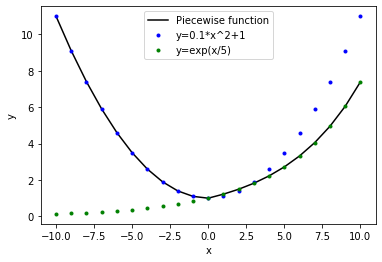

In [2]:
TINYDOUBLE = 1.0e-100
def coord_leq_bound(x,xstar): 
    # Returns 1.0 if x <= xstar, 0.0 otherwise. 
    # Requires appropriately defined TINYDOUBLE
    return min_noif(x-xstar-TINYDOUBLE,0.0)/(x-xstar-TINYDOUBLE)

def coord_geq_bound(x,xstar): 
    # Returns 1.0 if x >= xstar, 0.0 otherwise. 
    # Requires appropriately defined TINYDOUBLE
    return max_noif(x-xstar+TINYDOUBLE,0.0)/(x-xstar+TINYDOUBLE)

def coord_less_bound(x,xstar): 
    # Returns 1.0 if x < xstar, 0.0 otherwise. 
    # Requires appropriately defined TINYDOUBLE
    return min_noif(x-xstar,0.0)/(x-xstar-TINYDOUBLE)

def coord_greater_bound(x,xstar): 
    # Returns 1.0 if x > xstar, 0.0 otherwise. 
    # Requires appropriately defined TINYDOUBLE
    return max_noif(x-xstar,0.0)/(x-xstar+TINYDOUBLE)

# Now, define our the equation and plot it. 
x_data = np.arange(start = -10.0, stop = 11.0, step = 1.0)
y_data = coord_less_bound(x_data,0.0)*(0.1*x_data**2.0+1.0)\
        +coord_geq_bound(x_data,0.0)*np.exp(x_data/5.0)
    
plt.figure()
a = plt.plot(x_data,y_data,'k',label="Piecewise function")
b = plt.plot(x_data,0.1*x_data**2.0+1.0,'b.',label="y=0.1*x^2+1")
c = plt.plot(x_data,np.exp(x_data/5.0),'g.',label="y=exp(x/5)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


The plot above shows the expected piecewise-defined function. It is important in applying these functions that each greater-than be paired with a less-than-or-equal-to, or vice versa. Otherwise, the way these are written, a point on the boundary will be set to zero or twice the expected value. 

These functions can be easily combined for more complicated piecewise-defined functions; if a piece of a function is defined as $f(x)$ on $x^*_- \leq x < x^*_+$, for instance, simply multiply by both functions, e.g. 
```
coord_geq_bound(x,x_star_minus)*coord_less_bound(x,x_star_plus)*f(x)
```

<a id='sympy'></a>

# Step 3: Rewrite functions to work with symbolic expressions \[Back to [top](#toc)\]
$$\label{sympy}$$

In order to use this with sympy expressions in NRPy+, we will need to rewrite the `min` and `max` functions with slightly different syntax. Critically, we will change `0.5` to `sp.Rational(1,2)` and calls to `np.absolute()` to `nrpyAbs()`. We will also need to import `outputC.py` here for access to `nrpyAbs()`. The other functions will not require redefinition, because they only call specific combinations of the `min` and `max` function. 

In practice, we want to use `nrpyAbs()` and *not* `sp.Abs()` with our symbolic expressions, which will force `outputC` to use the C function `fabs()`, and not try to multiply the argument by its complex conjugate and then take the square root.

In [3]:
from outputC import *            # NRPy+: Core C code output module

def min_noif(a,b):
    # Returns the minimum of a and b
    return sp.Rational(1,2) * (a+b-nrpyAbs(a-b))

def max_noif(a,b):
    # Returns the maximum of a and b
    return sp.Rational(1,2) * (a+b+nrpyAbs(a-b))

<a id='validation'></a>

# Step 4: Validation against `Min_Max_and_Piecewise_Expressions` NRPy+ module \[Back to [top](#toc)\]
$$\label{validation}$$

As a code validation check, we will verify agreement in the SymPy expressions for plane-wave initial data for the Scalar Wave equation between
1. this tutorial and 
2. the NRPy+ [Min_Max_and_Piecewise_Expressions](../edit/Min_Max_and_Piecewise_Expressions.py) module.

In [4]:
# Reset & redefine TINYDOUBLE for proper comparison
%reset_selective -f TINYDOUBLE
TINYDOUBLE = par.Cparameters("REAL", thismodule, "TINYDOUBLE", 1e-100)

import Min_Max_and_Piecewise_Expressions as noif
all_passed=0

def comp_func(expr1,expr2,basename,prefixname2="noif."):
    passed = 0
    if str(expr1-expr2)!="0":
        print(basename+" - "+prefixname2+basename+" = "+ str(expr1-expr2))
        passed = 1
    return passed

a,b = sp.symbols("a b")

here = min_noif(a,b)
there = noif.min_noif(a,b)
all_passed += comp_func(here,there,"min_noif")

here = max_noif(a,b)
there = noif.max_noif(a,b)
all_passed += comp_func(here,there,"max_noif")

here = coord_leq_bound(a,b)
there = noif.coord_leq_bound(a,b)
all_passed += comp_func(here,there,"coord_leq_bound")

here = coord_geq_bound(a,b)
there = noif.coord_geq_bound(a,b)
all_passed += comp_func(here,there,"coord_geq_bound")

here = coord_less_bound(a,b)
there = noif.coord_less_bound(a,b)
all_passed += comp_func(here,there,"coord_less_bound")

here = coord_greater_bound(a,b)
there = noif.coord_greater_bound(a,b)
all_passed += comp_func(here,there,"coord_greater_bound")

import sys
if all_passed==0:
    print("ALL TESTS PASSED!")
else:
    print("ERROR: AT LEAST ONE TEST DID NOT PASS")
    sys.exit(1)

ALL TESTS PASSED!


<a id='latex_pdf_output'></a>

# Step 5: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Min_Max_and_Piecewise_Expressions.pdf](Tutorial-Min_Max_and_Piecewise_Expressions.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [5]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx --log-level='WARN' Tutorial-Min_Max_and_Piecewise_Expressions.ipynb
!pdflatex -interaction=batchmode Tutorial-Min_Max_and_Piecewise_Expressions.tex
!pdflatex -interaction=batchmode Tutorial-Min_Max_and_Piecewise_Expressions.tex
!pdflatex -interaction=batchmode Tutorial-Min_Max_and_Piecewise_Expressions.tex
!rm -f Tut*.out Tut*.aux Tut*.log

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
